# <font color="maroon">Chapter 7: Cross-Correlated Dynamics via iRED</font>

One approach to interpreting detector analyses is to understand how local motion is connected to overall motion. In this tutorial, we will perform cross-correlation analysis via [iRED](https://pubs.acs.org/doi/10.1021/ja012750u). This analysis has been applied to identify mode dynamics in [HET-s(218-289)](https://onlinelibrary.wiley.com/doi/full/10.1002/anie.201901929) and establish connections between the G-protein binding site and other locations in [GHSR](https://onlinelibrary.wiley.com/doi/10.1002/anie.202302003).

## Setup and data downloads
Since we've learned now how pyDR is organized and allows us to manage larger data sets, we'll now use the full project functionality.

In [1]:
# SETUP pyDR
import os
os.chdir('..')

In [2]:
#Imports / download
import pyDR

In [3]:
#Download MD files if running in Colab (hidden on webpage)
import sys
if 'google.colab' in sys.modules:
    from gdown import download
    ID='1xgp5_BVeCh6Weu4tnsl1ToRZR49eM5hW'   #HETs xtc file
    #Just grab this string out of the google drive share link 'https://drive.google.com/file/d/1xgp5_BVeCh6Weu4tnsl1ToRZR49eM5hW/view?usp=share_link'
    download(f'https://drive.google.com/uc?id={ID}','/content/pyDR/examples/HETs15N/backboneB.xtc')

In [4]:
# Project Creation and File loading
proj=pyDR.Project()

sel=pyDR.MolSelect(topo='pyDR/examples/HETs15N/backboneB.pdb',
                   traj_files='pyDR/examples/HETs15N/backboneB.xtc',
                   project=proj)  #Selection object

# Specify the bond select to analyze for MD
sel.select_bond('N')

## Load and process MD without and with iRED
When using iRED, it's important to compare the dynamics obtained with iRED and with a direct calculation of the detector responses. iRED works by determining modes of reorientational motion that are independent from each other. Then, the cross-correlation between modes is, by definition, zero at the initial time. However, there is no guarantee that the modes remain independent at a later time. If the direct and iRED calculations are in good agreement for a given bond, then the majority of motion for that bond results from independent mode motions which remain mostly independent. However, if not, then the total motion of that bond may have significant contributions from [time-lagged cross-correlation](https://pubs.aip.org/aip/jcp/article/139/1/015102/192538/Identification-of-slow-molecular-order-parameters) between modes, and the iRED analysis is not necessarily a good representation of its total motion.

Note that we'll do a rank 1 calculation here for iRED, since it simplifies the orientational dependence.

In [5]:
sel.traj.step=10  #Take every tenth point for MD calculation (set to 1 for more accurate calculation)
pyDR.Defaults['ProgressBar']=False #Turns off the Progress bar (screws up webpage compilation)

pyDR.md2data(sel,rank=1) #Direct calculation
ired=pyDR.md2iRED(sel,rank=1)  #iRED object
ired.iRED2data() #Send iRED results to proj

r:IREDMODE:rk1:backboneB with 70 data points


Next, we set up the detectors for the raw data. We'll do a pre-processing with 10 unoptimized detectors.

In [6]:
proj['raw'].detect.r_no_opt(10)
proj['raw'].fit()

Fitted 2 data objects
pyDIFRATE project with 2 data sets

Titles:
n10:MD:rk1:backboneB
n10:IREDMODE:rk1:backboneB


Next, we use 7 optimized detectors, and finally conclude with an optimization of the results, including cleanup of the detector sensitivities.

In [7]:
proj['no_opt'].detect.r_auto(6)
proj['no_opt'].fit().opt2dist(rhoz_cleanup=True)

Fitted 2 data objects
Optimized 2 data objects
pyDIFRATE project with 2 data sets

Titles:
o6:MD:rk1:backboneB
o6:IREDMODE:rk1:backboneB


We now plot the results of the direct and iRED analysis.

## Plot the results

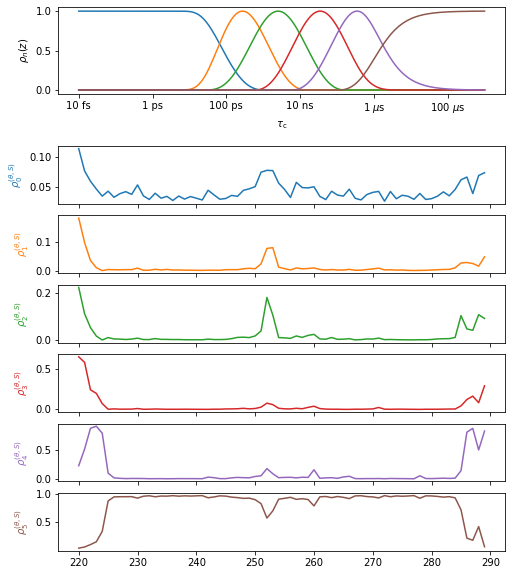

In [8]:
proj.close_fig('all')
proj['opt_fit']['MD'].plot().fig.set_size_inches([8,10])

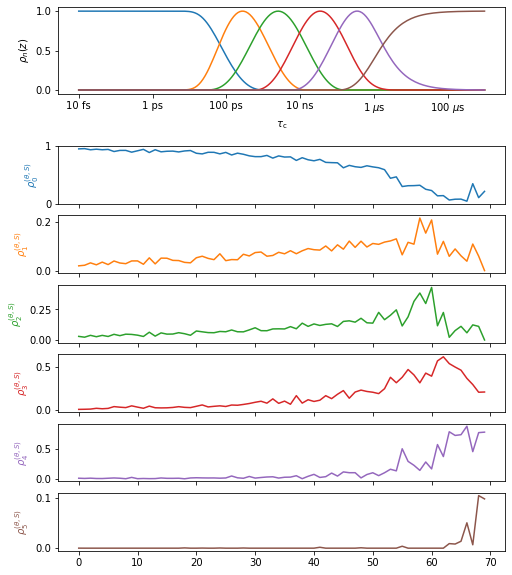

In [9]:
proj.close_fig('all')
proj['opt_fit']['iREDmode'].plot().fig.set_size_inches([8,10])

### Converting modes to bonds
The second plot is completely different than the first. So what's happening? In fact, this is the detector analysis of the iRED modes, where those modes still need to be projected onto the bonds. The modes are sorted by size, from smallest to largest, where the tendency is that larger modes are also slower, although this is certainly not an absolute rule.

Modes are converted to bonds using .modes2bonds. We will run this and then overlay the results with the direct calculation.

In [10]:
proj['opt_fit'].modes2bonds()

Converted 1 iRED data objects from modes to bonds
pyDIFRATE project with 1 data sets

Titles:
o6:IREDBOND:rk1:backboneB


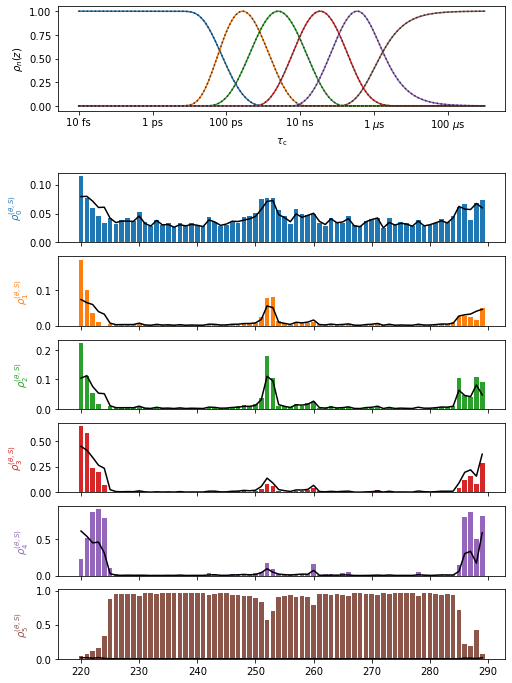

In [11]:
proj.close_fig('all')
proj['opt_fit']['MD'].plot(style='bar').fig.set_size_inches([8,12])
proj['opt_fit']['iREDbond'].plot()
# for a in proj.plot_obj.ax:a.set_ylim([0,.05])

In particularly flexible regions, there is some disagreement between the two analyses, but otherwise we have done fairly well with the iRED mode decomposition. In these flexible regions, we should keep in mind that mode dynamics yields an incomplete description of the total motion and the cross-correlation coefficients are not representing the full motion.

Note that iRED adds an isotropic average over all motions (*isotropic* Reorientational Eigenmode Dynamics), which usually manifests as some overall motion in the 3 or 5 (rank-1,2) largest eigenvalues. We remove the overall isotropic motion by removing these 3-5 modes when running .modes2bonds (although we don't have to, set inclOverall=True), which has the result that $\rho^{(\theta,S)}_5$ does not capture the static component of each bond, whereas the direct calculation does. Then, $\rho^{(\theta,S)}_5$ of the direct calculation is large, but it becomes almost zero in the iRED calculation. This should not be considered disagreement between the methods, but rather an artifact of the analysis.

This artifact also means that one should not run .opt2dist on iREDbond data, since part of the motion is missing and therefore the distribution cannot be corrected (anyway, we have already run opt2dist on the mode data, so we don't gain anything by running it again).

### Plotting cross-correlation matrix
We first plot the cross-correlation matrices (using the absolute normalized cross-correlation, ranging from 0 to 1).

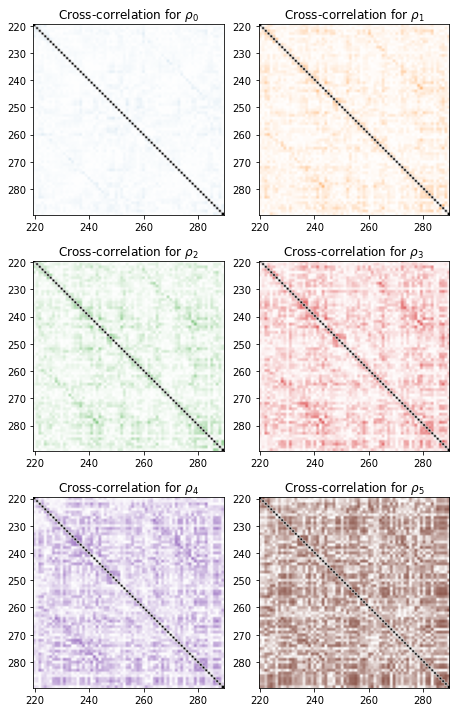

In [12]:
import numpy as np
fig=proj['opt_fit']['iREDbond'].plot_CC(rho_index=np.arange(6))[0].figure
fig.set_size_inches([12,10])
fig.tight_layout()

### 3D Representations in ChimeraX
Finally, if running locally, we can plot in ChimeraX. In ChimeraX, we can select a given bond (or atom in the bond/representative selection), and then mouse over one of the detectors in the upper right corner to view the cross-correlation to the selected bond.

In [13]:
# proj.chimera.close()
proj['iREDbond'][-1].CCchimera()
proj.chimera.command_line(['set bgColor white','lighting soft','~show ~@N,C,CA,H,N'])

0


Pick a bond in ChimeraX, ideally in a $\beta$-sheet region. (e.g., type "sel :272@N" on the ChimeraX command line, or from Jupyter, run proj.chimera.command_line('sel :272@N')). Then, mouse over each of the 6 detectors. Notice what happens: as we go from short correlation times (blue) to longer correlation times, the degree and distance of cross-correlation increases. What's happening is that we're seeing different modes of motion for different ranges of correlation times, with the tendency that slower motion corresponds to longer range modes (since more atoms are involved, there's a higher energy cost which translates into slower dynamics). These trends exist for most residues in the $\beta$-sheet region.

## Streamlined Processing
It's worth mentioning that pyDR processing is highly efficient. While we insert a lot of steps here to demonstrate what's going on, the whole iRED procedure is indeed only a few lines of code:
```
proj=pyDR.Project()
sel=pyDR.MolSelect(topo='../pyDR/examples/HETs15N/backboneB.pdb',
                   traj_files='../pyDR/examples/HETs15N/backboneB.xtc',
                   project=proj).select_bond('N')  #Selection object
sel.traj.step=10 #Skips frames for faster processing

pyDR.md2data(sel,rank=1) #Create data for direct calculation
ired=pyDR.md2iRED(sel,rank=1).iRED2data()  #Create data for iRED

proj['raw'].detect.r_no_opt(10)  #Optimize no opt detectors
proj['raw'].fit()

proj['no_opt'].detect.r_auto(6)    #Optimized detectors
proj['no_opt'].fit().opt2dist(rhoz_cleanup=True).modes2bonds() #Fit, optimize, convert modes to bonds
```